## Campos involucrados

- direccion
- idzona
- ciudad
- provincia
- lat
- lng

## Objetivos

- Normalizar (provincia, ciudad, dirección)
- Agregar información (geometry)
- Métodos para graficar (cantidad+densidad)
- Método para definir si x publicación está en una geometry

- Agregar información externa (distrito electoral, etc.)


In [1]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

In [3]:
#importo las funciones para levantar los dataframes
%run "../../utils/dataset_parsing.ipynb"
#importo las funciones para graficar
%run "../../utils/graphs.ipynb"

In [7]:
pais = geopandas.read_file("./MEX_adm/MEX_adm0.shp")
estados = geopandas.read_file("./MEX_adm/MEX_adm1.shp")
municipios = geopandas.read_file("./MEX_adm/MEX_adm2.shp")
ciudades = geopandas.read_file("./México_Centros_Urbanos/México_Centros_Urbanos.shp")

In [56]:
df = levantar_datos("../../"+DATASET_RELATIVE_PATH)
con_gps = df.loc[~ (df["lat"].isna() & df["lng"].isna())]
con_gps["coord_point"] = con_gps.apply(lambda x: Point(x["lng"],x["lat"]), axis=1)

c:\users\dev\repos\fiuba\75-06\2019-2\tp\.venv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [76]:
def esta_en_mexico(point: Point) -> bool:
    """ 
        Recibe un punto (lat,lng) y devuelve (muy aproximadamente) True si está dentro de Mexico, False si no.
        Hacerlo con ```df["coord"].map(lambda x: mexico_polygon.contains(x))``` sería muy lento.
    """
    MEX_MIN_LNG, MEX_MAX_LNG = (-120, -85)
    MEX_MIN_LAT, MEX_MAX_LAT = (14,33)
    return (MEX_MIN_LNG < point.x < MEX_MAX_LNG) and (MEX_MIN_LAT < point.y < MEX_MAX_LAT)

In [82]:
con_gps["en_mexico"] = con_gps["coord_point"].map(esta_en_mexico)

c:\users\dev\repos\fiuba\75-06\2019-2\tp\.venv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [83]:
con_gps["en_mexico"].value_counts()

True     115871
False       641
Name: en_mexico, dtype: int64

In [87]:
fuera_de_mexico = con_gps.loc[~con_gps["en_mexico"]]
en_mexico = con_gps.loc[con_gps["en_mexico"]]

In [88]:
validos = geopandas.GeoDataFrame(en_mexico, geometry="coord_point")

In [61]:
mexico_polygon = pais.iloc[0]["geometry"]

In [131]:
def dibujar_mexico(puntos):
    grafico = pais.plot(figsize=(18,9))
    estados.plot(ax=grafico, color="white")
#     municipios.plot(ax=grafico, color="white")
    # ciudades.plot(ax=grafico, color="yellow")
    puntos.plot(ax=grafico, color="green")

In [122]:
# le cambio los nombres a las siguientes provincias, para que coincidan con mi info geografica 
provincias_mapper = {
    "Baja California Norte": "Baja California",
    "Edo. de México": "México",
    "San luis Potosí": "San Luis Potosí"
}
validos["provincia"] = validos["provincia"].map(lambda x: provincias_mapper.get(x, x))
set(validos["provincia"].dropna().unique()) == set(estados["NAME_1"]) #verifico

True

In [163]:
# estos tienen datos gps pero no de provincia
sin_provincia = validos.loc[validos["provincia"].isna()]

def buscar_provincia(punto: Point, provincias):
    """
        Devuelve en qué provincia de mexico se encuentra el punto.
    """
    for provincia, geometry in provincias[["NAME_1","geometry"]].values:
        if geometry.contains(punto): return provincia
    return None

# agrego las provincias faltantes
sin_provincia["provincia"] = sin_provincia["coord_point"].map(lambda x: buscar_provincia(x, estados))

c:\users\dev\repos\fiuba\75-06\2019-2\tp\.venv\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [164]:
validos.loc[validos["provincia"].isna()]

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,...,piscina,escuelascercanas,centroscomercialescercanos,precio,mes,ano,dia,coord_point,en_mexico,estado
18733,159025,casa de 4 habitaciones y 2 baños en venta,<p>.</p>,Casa,PROL. ANAHUAC 225,NaN,NaN,15.0,4.0,0.0,...,False,True,False,580000.0,2,2014,8,POINT (-100.99272251129 22.162050103963),True,NaN
18785,5467,departamento en venta,"ubicado en calle muy tranquila. es interior, c...",Apartamento,NaN,NaN,NaN,NaN,2.0,1.0,...,False,False,False,4050000.0,7,2016,16,POINT (-99.1796224 19.39131260000001),True,NaN
24001,121143,"precioso departamento en venta en la condesa, ...",<p> precioso departamento se vende en muy buen...,Apartamento,Aguascalientes,NaN,NaN,5.0,3.0,NaN,...,False,False,False,4650000.0,7,2016,16,POINT (-99.16931979999998 19.4078742),True,NaN
31333,192696,casa de 6 habitaciones y 2 baños en venta,<p>.</p>,Casa,INDEPENDENCIA 115,NaN,NaN,0.0,6.0,0.0,...,False,True,False,790000.0,2,2014,8,POINT (-100.98072767258 22.156525470192),True,NaN
36796,193515,precioso departamento nuevo en el norte de la ...,"<p>excelente departamento practicamente nuevo,...",Apartamento,Eje Central Lazaro Cardenas,NaN,NaN,1.0,2.0,NaN,...,False,False,False,1490000.0,7,2016,15,POINT (-99.14176862686872 19.48069456756218),True,NaN
43141,239562,casa de 4 habitaciones en venta,la entrada principal cuenta con escaleras y ra...,Casa,HACIENDA EL HUIZACHE 1,NaN,NaN,2.0,4.0,2.0,...,False,True,False,2850000.0,1,2014,16,POINT (-100.44040203094 20.535238080481),True,NaN
53755,150624,departamento en pre venta en josé maría rico,<p>departamento en venta en colonia del valle ...,Apartamento,José Mária Rico,NaN,NaN,NaN,2.0,NaN,...,False,True,True,4595000.0,7,2016,17,POINT (-99.17225550000001 19.3706835),True,NaN
64366,222321,departamento nuevo en venta en atmosfera coyoacan,<p>departamentos nuevos en venta en atmósfera ...,Apartamento,Av. Universidad,NaN,NaN,NaN,2.0,NaN,...,False,False,False,3411600.0,7,2016,17,POINT (-99.1667893 19.3644635),True,NaN
64653,59459,casa de 6 habitaciones y 3 baños en venta,"casa ampliada a 3 niveles, entrada a la segund...",Casa,CALLE SANTA MONICA 0,NaN,NaN,20.0,6.0,1.0,...,False,True,False,1250000.0,2,2014,4,POINT (-100.4302740097 20.602819949471),True,NaN
69186,46636,bodega-galpon en venta,<p>terreno: 230 m2</p>\n<p>bodega: 230 m2</p>\...,Bodega comercial,Emiliano Zapata 22,NaN,NaN,27.0,NaN,NaN,...,False,False,False,4100000.0,2,2014,18,POINT (-99.22797918319701 19.461170216115),True,NaN


In [161]:
sin_provincia

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,...,piscina,escuelascercanas,centroscomercialescercanos,precio,mes,ano,dia,coord_point,en_mexico,estado
18733,159025,casa de 4 habitaciones y 2 baños en venta,<p>.</p>,Casa,PROL. ANAHUAC 225,NaN,San Luis Potosí,15.0,4.0,0.0,...,False,True,False,580000.0,2,2014,8,POINT (-100.99272251129 22.162050103963),True,NaN
18785,5467,departamento en venta,"ubicado en calle muy tranquila. es interior, c...",Apartamento,NaN,NaN,Distrito Federal,NaN,2.0,1.0,...,False,False,False,4050000.0,7,2016,16,POINT (-99.1796224 19.39131260000001),True,NaN
24001,121143,"precioso departamento en venta en la condesa, ...",<p> precioso departamento se vende en muy buen...,Apartamento,Aguascalientes,NaN,Distrito Federal,5.0,3.0,NaN,...,False,False,False,4650000.0,7,2016,16,POINT (-99.16931979999998 19.4078742),True,NaN
31333,192696,casa de 6 habitaciones y 2 baños en venta,<p>.</p>,Casa,INDEPENDENCIA 115,NaN,San Luis Potosí,0.0,6.0,0.0,...,False,True,False,790000.0,2,2014,8,POINT (-100.98072767258 22.156525470192),True,NaN
36796,193515,precioso departamento nuevo en el norte de la ...,"<p>excelente departamento practicamente nuevo,...",Apartamento,Eje Central Lazaro Cardenas,NaN,Distrito Federal,1.0,2.0,NaN,...,False,False,False,1490000.0,7,2016,15,POINT (-99.14176862686872 19.48069456756218),True,NaN
43141,239562,casa de 4 habitaciones en venta,la entrada principal cuenta con escaleras y ra...,Casa,HACIENDA EL HUIZACHE 1,NaN,Querétaro,2.0,4.0,2.0,...,False,True,False,2850000.0,1,2014,16,POINT (-100.44040203094 20.535238080481),True,NaN
53755,150624,departamento en pre venta en josé maría rico,<p>departamento en venta en colonia del valle ...,Apartamento,José Mária Rico,NaN,Distrito Federal,NaN,2.0,NaN,...,False,True,True,4595000.0,7,2016,17,POINT (-99.17225550000001 19.3706835),True,NaN
64366,222321,departamento nuevo en venta en atmosfera coyoacan,<p>departamentos nuevos en venta en atmósfera ...,Apartamento,Av. Universidad,NaN,Distrito Federal,NaN,2.0,NaN,...,False,False,False,3411600.0,7,2016,17,POINT (-99.1667893 19.3644635),True,NaN
64653,59459,casa de 6 habitaciones y 3 baños en venta,"casa ampliada a 3 niveles, entrada a la segund...",Casa,CALLE SANTA MONICA 0,NaN,Querétaro,20.0,6.0,1.0,...,False,True,False,1250000.0,2,2014,4,POINT (-100.4302740097 20.602819949471),True,NaN
69186,46636,bodega-galpon en venta,<p>terreno: 230 m2</p>\n<p>bodega: 230 m2</p>\...,Bodega comercial,Emiliano Zapata 22,NaN,México,27.0,NaN,NaN,...,False,False,False,4100000.0,2,2014,18,POINT (-99.22797918319701 19.461170216115),True,NaN


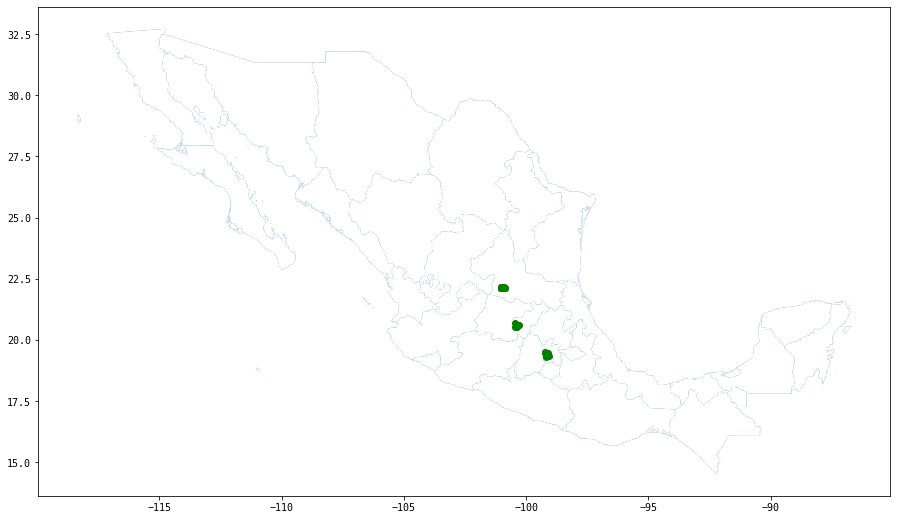

In [162]:
dibujar_mexico(sin_provincia)